In [2]:

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt



from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from mrcnn.utils import extract_bboxes

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = './'

# Local path to trained weights file
COCO_MODEL_PATH = "mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    #utils.download_trained_weights(COCO_MODEL_PATH)
    print("It doesnot exist")
else: print("It exists")

Using TensorFlow backend.


It exists


In [5]:

class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100
    
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 1.
    }

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [7]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [8]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [9]:
8//4

2

In [3]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "parasite")
        self.add_class("shapes", 2, "non_parasite")
        

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        
        cv2.circle(image, (x, y), s, color, -1)
        
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["parasite", "non_parasite"])
        color_temp = []
        if shape=="non_parasite":
            color_temp = [ random.randint(100, 115) for _ in range(3)]
        else:
            color_temp = [random.randint(20, 35) for _ in range(3)]
        # Color
        color = tuple(color_temp)
        # Center x, y
        buffer = 15
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        #bg_color = []
        #bg_random = random.choice(["rouge","bleu"])
        #if bg_random == "rouge":
        #    bg_color = [255,0,0]
        #else : bg_color = [0,0,255]
        
        bg_color = np.array([240 for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(3, 8)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [135]:
config.IMAGE_SHAPE[1]

128

In [6]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

In [8]:
dataset_train.load_mask(5)

(array([[[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        ...,
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
         [False, False, False],
         [False, False, False]],
 
        [[False, False, False],
         [False, False, False],
         [False, False, False],
         ...,
         [False, False, False],
       

In [12]:
from PIL import Image  
import PIL  

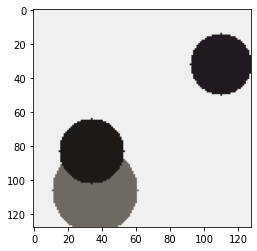

In [15]:
plt.imshow(dataset_val.load_image(1))

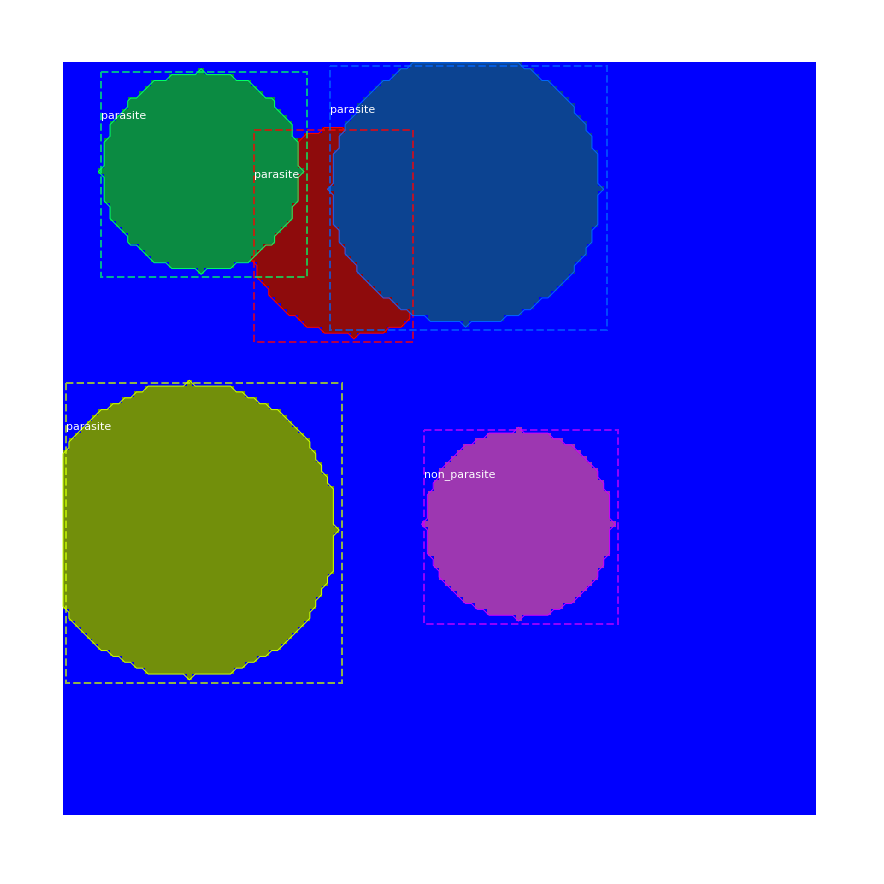

In [64]:
from mrcnn.visualize import display_instances
# define image id
image_id = 1
# load the image
image = dataset_val.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_val.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [55]:
mask, class_ids = dataset_train.load_mask(image_id)
class_ids

array([1, 1, 2, 2])

In [23]:
for i in range(20):
    plt.imsave("cercle_images/monimage"+str(i)+".jpg",dataset_train.load_image(i))

In [33]:
plt.imsave("testimage22.jpg",dataset_train.load_image(22))

In [7]:
dataset_val.class_names

['BG', 'parasite', 'non_parasite']

non_parasite


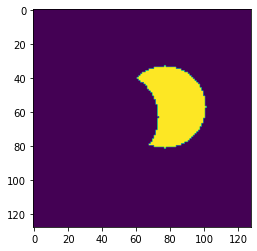

In [8]:
i = 4
print(dataset_val.class_names[dataset_val.load_mask(21)[1][i]])
plt.imshow(dataset_val.load_mask(21)[0][:,:,i])

In [8]:
dataset_train.class_names

['BG', 'square', 'circle', 'triangle']

In [110]:
img = dataset_train.load_image(0)
type(img)

numpy.ndarray

In [199]:
dataset_val.load_mask(21)[0][100]

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, Fal

TypeError: Invalid shape (128, 128, 5) for image data

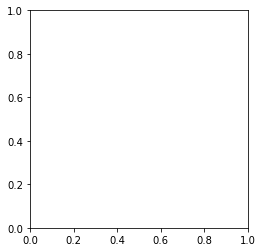

In [194]:
plt.imshow(dataset_val.load_mask(21)[0])

In [87]:
pd.DataFrame(dataset_train.load_mask(1)[1])[0].value_counts()[0:1]

2    2
Name: 0, dtype: int64

In [88]:
import pandas as pd
un = 0 
deux = 0
for i in range(len(dataset_train.image_ids)):
    un+= pd.DataFrame(dataset_train.load_mask(1)[1])[0].value_counts()[1:2]
    deux+= pd.DataFrame(dataset_train.load_mask(1)[1])[0].value_counts()[0:1]
    #print(pd.DataFrame(dataset_train.load_mask(i)[1]).value_counts())

In [89]:
print(un,deux)

1    1000
Name: 0, dtype: int64 2    1000
Name: 0, dtype: int64


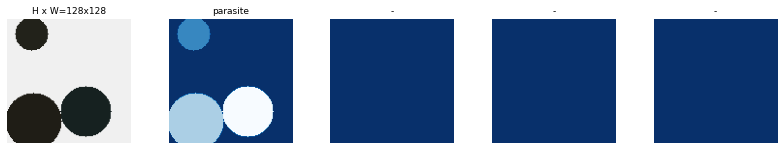

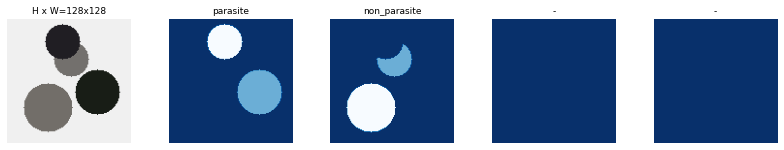

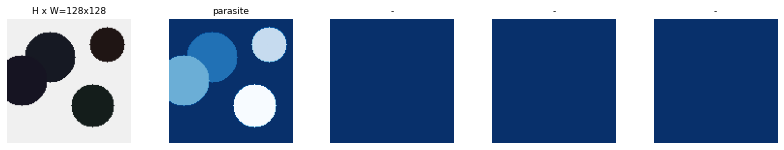

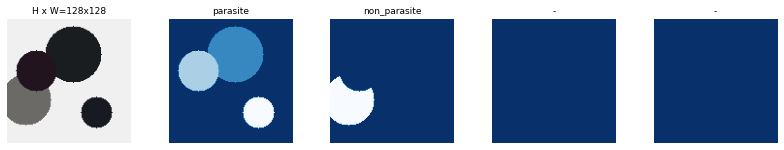

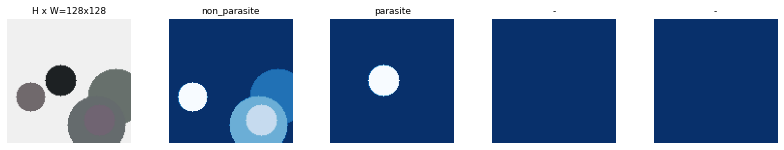

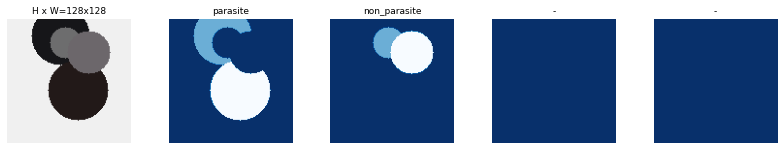

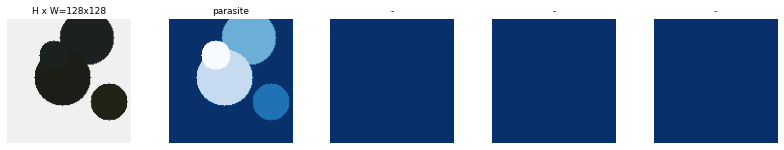

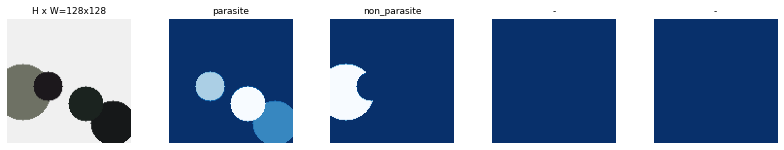

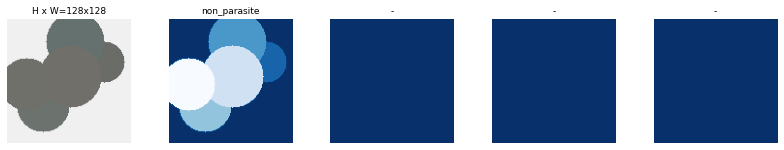

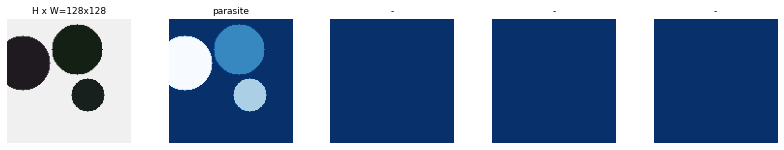

In [141]:
import cv2
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in range(20,30):
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

In [ ]:
for 

In [147]:

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [148]:
model.load_weights("shape_training/mask_rcnn_coco_3.h5", by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [149]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

fpn_c4p4 (Conv2D)               (None, None, None, 2 262400      res4w_out[0][0]                  
__________________________________________________________________________________________________
fpn_p4add (Add)                 (None, None, None, 2 0           fpn_p5upsampled[0][0]            
                                                                 fpn_c4p4[0][0]                   
__________________________________________________________________________________________________
fpn_p4upsampled (UpSampling2D)  (None, None, None, 2 0           fpn_p4add[0][0]                  
__________________________________________________________________________________________________
fpn_c3p3 (Conv2D)               (None, None, None, 2 131328      res3d_out[0][0]                  
__________________________________________________________________________________________________
fpn_p3add (Add)                 (None, None, None, 2 0           fpn_p4upsampled[0][0]            
          

In [70]:
history = LossHistory()
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.keras_model.metrics_tensors = []
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=3, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./shapes20200423T1421\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistrib

c:\users\h.de.montalembert\anaconda3\envs\rcnn-env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\h.de.montalembert\anaconda3\envs\rcnn-env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\h.de.montalembert\anaconda3\envs\rcnn-env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/3
 47/100 [=============>................] - ETA: 1:29:58 - loss: 4.5822

KeyboardInterrupt: 

#### Azure Machine Learning 

In [2]:
from azureml.core import Workspace
ws = Workspace.from_config(path="config.json")

WARNING - Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"


Performing interactive authentication. Please follow the instructions on the terminal.


WARNING - You have logged in. Now let us find all the subscriptions to which you have access...


Interactive authentication successfully completed.


In [3]:
ws.get_details()['applicationInsights']

'/subscriptions/2053edae-d407-44dc-af3f-7bf9f0600894/resourcegroups/project_henri_estus/providers/microsoft.insights/components/azuremlworkspa1726646641'

In [10]:
print(ws.name, ws.resource_group , ws.subscription_id  , ws.models , sep="\n")

azureml-workspace
project_henri_estus
2053edae-d407-44dc-af3f-7bf9f0600894
{}


In [168]:
p = 7
#nb = 0
nb += 1 if p ==5 else 0
print(nb)

3


In [152]:
%%time 
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "aml-cluster"

try:
    #Check for existing compute target
    training_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # If it doesn't already exist, create it
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', max_nodes=2)
    training_cluster = ComputeTarget.create(ws, cluster_name, compute_config)

training_cluster.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
Wall time: 11min 8s


In [12]:
from azureml.train.estimator import Estimator
from azureml.core import Environment, Experiment
from azureml.widgets import RunDetails
from azureml.train.dnn import TensorFlow
from azureml.core import Model
#images/04-03-2020_013625_UTC/
#annots/04-03-2020_013806_UTC/

cluster_name = "aml-cluster"
#cluster_name = "dsvm-test2"

# Get the environment
#registered_env = Environment.get(ws, 'training_environment')
my_model = 'mask_rcnn_coco_3.h5'
print("henri")
# Set the script parameters
script_params = {
    '--export': './outputs',
    '--epochs': 3,
    '--model-path': my_model
}
#'--data-folder': dataset.as_named_input('material').as_mount(),
# Get the training dataset

project_folder = 'shape_training'


experiment = Experiment(workspace = ws, name = 'shape_mrcnn-training')

# Create an estimator
estimator = TensorFlow(source_directory=project_folder,
                      script_params=script_params,
                      pip_packages = ['tensorflow==1.15','mrcnn==0.2' ,'keras==2.3.1','scikit-image','IPython','opencv-python'],#,'https://github.com/matterport/Mask_RCNN.git'#"tensorflow-gpu==2.0.0",
                      compute_target = cluster_name, # Run the experiment on the remote compute target
                      #environment_definition = registered_env,
                      entry_script='train.py',
                      #framework_version='1.13'
                      )



# Run the experiment
run = experiment.submit(config=estimator)
# Show the run details while running
RunDetails(run).show()
run.wait_for_completion()

henri


framework_version is not specified, defaulting to version 1.13.
You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['tensorflow']. We cannot guarantee image build will succeed.


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

KeyboardInterrupt: 

### Test of the model

In [161]:
os.path.abspath("outputs")

'C:\\Users\\h.de.montalembert\\Documents\\ComputerVision\\Shape_detection\\outputs'

In [16]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN


class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "Shape_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 2
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
# create config

cfg = PredictionConfig()
# define the model

model = MaskRCNN(mode='inference'
                 , model_dir="./"#"outputs"
                 , config=cfg)
model.load_weights('mask_rcnn_shapes_0013.h5', by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [24]:
model.keras_model.outputs[0].

0

In [57]:
def load_image_gt2(dataset, config, image_id, augment=False, augmentation=None,
                  use_mini_mask=False):
    """Load and return ground truth data for an image (image, mask, bounding boxes).
    augment: (deprecated. Use augmentation instead). If true, apply random
        image augmentation. Currently, only horizontal flipping is offered.
    augmentation: Optional. An imgaug (https://github.com/aleju/imgaug) augmentation.
        For example, passing imgaug.augmenters.Fliplr(0.5) flips images
        right/left 50% of the time.
    use_mini_mask: If False, returns full-size masks that are the same height
        and width as the original image. These can be big, for example
        1024x1024x100 (for 100 instances). Mini masks are smaller, typically,
        224x224 and are generated by extracting the bounding box of the
        object and resizing it to MINI_MASK_SHAPE.
    Returns:
    image: [height, width, 3]
    shape: the original shape of the image before resizing and cropping.
    class_ids: [instance_count] Integer class IDs
    bbox: [instance_count, (y1, x1, y2, x2)]
    mask: [height, width, instance_count]. The height and width are those
        of the image unless use_mini_mask is True, in which case they are
        defined in MINI_MASK_SHAPE.
    """
    # Load image and mask
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    original_shape = image.shape
    

    # Random horizontal flips.
    # TODO: will be removed in a future update in favor of augmentation
    if augment:
        logging.warning("'augment' is deprecated. Use 'augmentation' instead.")
        if random.randint(0, 1):
            image = np.fliplr(image)
            mask = np.fliplr(mask)

    # Augmentation
    # This requires the imgaug lib (https://github.com/aleju/imgaug)
    if augmentation:
        import imgaug

        # Augmenters that are safe to apply to masks
        # Some, such as Affine, have settings that make them unsafe, so always
        # test your augmentation on masks
        MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                           "Fliplr", "Flipud", "CropAndPad",
                           "Affine", "PiecewiseAffine"]

        def hook(images, augmenter, parents, default):
            """Determines which augmenters to apply to masks."""
            return augmenter.__class__.__name__ in MASK_AUGMENTERS

        # Store shapes before augmentation to compare
        image_shape = image.shape
        mask_shape = mask.shape
        # Make augmenters deterministic to apply similarly to images and masks
        det = augmentation.to_deterministic()
        image = det.augment_image(image)
        # Change mask to np.uint8 because imgaug doesn't support np.bool
        mask = det.augment_image(mask.astype(np.uint8),
                                 hooks=imgaug.HooksImages(activator=hook))
        # Verify that shapes didn't change
        assert image.shape == image_shape, "Augmentation shouldn't change image size"
        assert mask.shape == mask_shape, "Augmentation shouldn't change mask size"
        # Change mask back to bool
        mask = mask.astype(np.bool)

    # Note that some boxes might be all zeros if the corresponding mask got cropped out.
    # and here is to filter them out
    _idx = np.sum(mask, axis=(0, 1)) > 0
    mask = mask[:, :, _idx]
    class_ids = class_ids[_idx]
    # Bounding boxes. Note that some boxes might be all zeros
    # if the corresponding mask got cropped out.
    # bbox: [num_instances, (y1, x1, y2, x2)]
    bbox = utils.extract_bboxes(mask)

    # Active classes
    # Different datasets have different classes, so track the
    # classes supported in the dataset of this image.
    active_class_ids = np.zeros([dataset.num_classes], dtype=np.int32)
    source_class_ids = dataset.source_class_ids[dataset.image_info[image_id]["source"]]
    active_class_ids[source_class_ids] = 1

    # Resize masks to smaller size to reduce memory usage
    if use_mini_mask:
        mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)



    return image, class_ids, bbox, mask

image ID: shapes.20 (20) [('non_parasite', (100, 105, 115), (22, 109, 18)), ('parasite', (28, 28, 34), (60, 27, 29)), ('parasite', (32, 22, 24), (82, 75, 24))]
Processing 1 images
image                    shape: (128, 128, 3)         min:  -95.70000  max:  136.10000  float64
molded_images            shape: (1, 1024, 1024, 3)    min: -219.40000  max:   32.20001  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


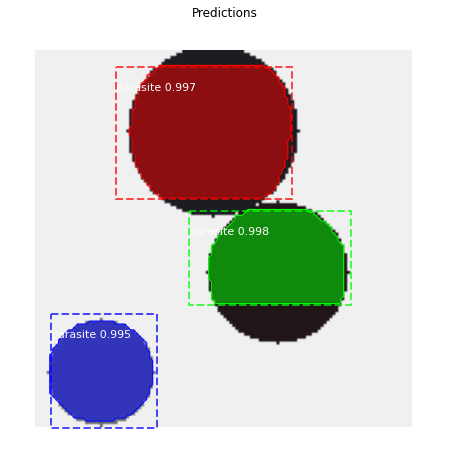

In [101]:
from mrcnn.model import mold_image
from numpy import expand_dims

image_id = 20
image, gt_class_id, gt_bbox, gt_mask = load_image_gt2(dataset_val, cfg, image_id, use_mini_mask=False)

sample = expand_dims(mold_image(image,cfg),0)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, dataset_val.image_reference(image_id)))
results = model.detect(sample, verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")


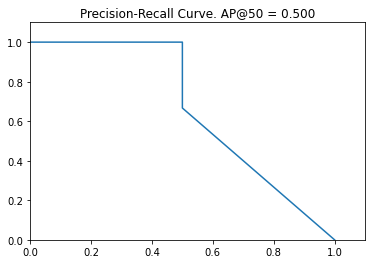

In [16]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [17]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min:   -1.09278  max:    2.15120  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 3756.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


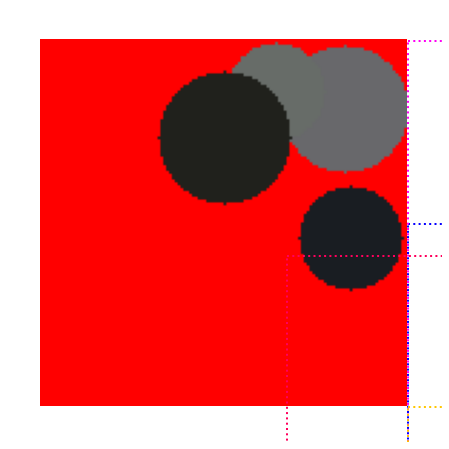

In [18]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

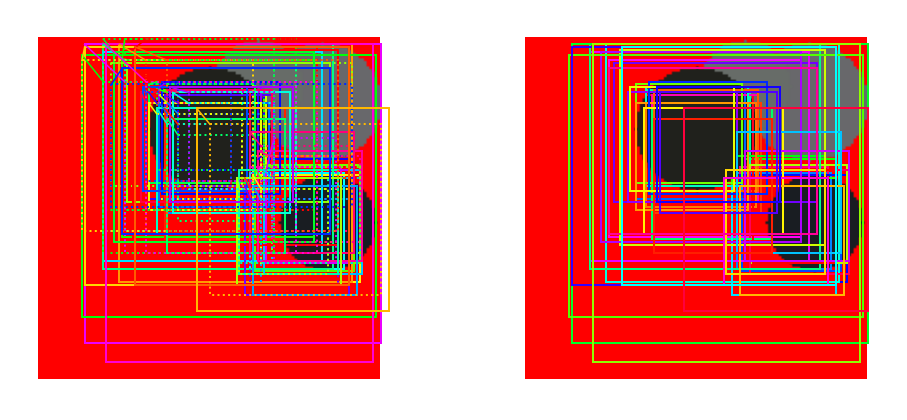

In [19]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

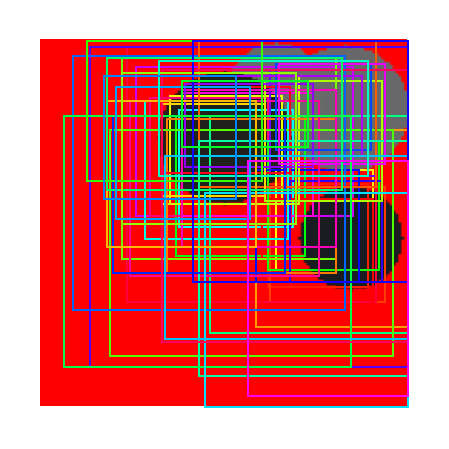

In [20]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

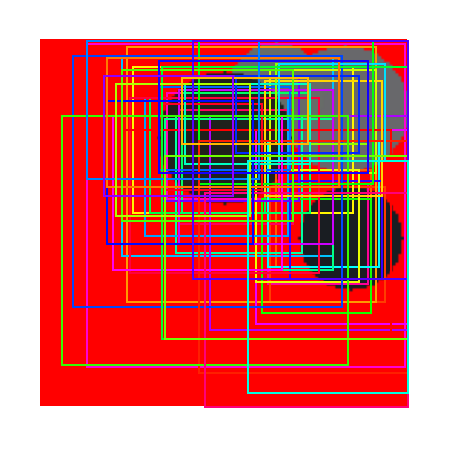

In [21]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [22]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))

All Anchors (261888)       Recall: 0.500  Positive anchors: 7
Refined Anchors ( 6000)   Recall: 0.000  Positive anchors: 0
Post NMS Anchors (   50)  Recall: 0.250  Positive anchors: 1


In [23]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 3, 4)       min:   -4.13434  max:    5.37098  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.00065  max:    0.99942  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32


2 detections: ['non_parasite' 'non_parasite']


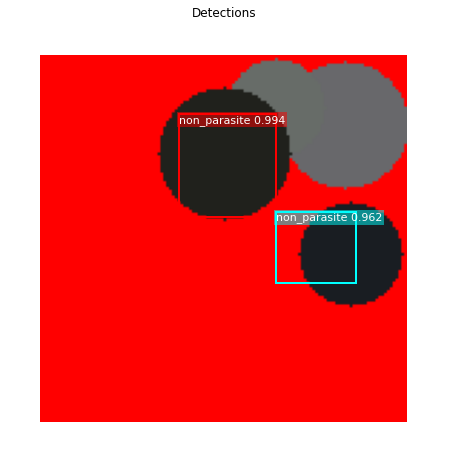

In [24]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_train.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_train.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [25]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_train.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
15 Positive ROIs
[('BG', 985), ('non_parasite', 15)]


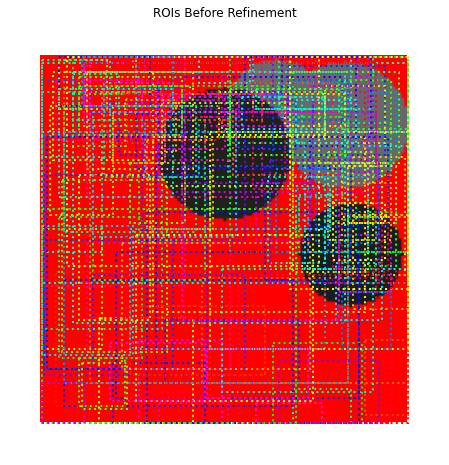

In [26]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

roi_bbox_specific        shape: (1000, 4)             min:   -4.13434  max:    5.37098  float32
refined_proposals        shape: (1000, 4)             min:  -57.00000  max:  165.00000  int32


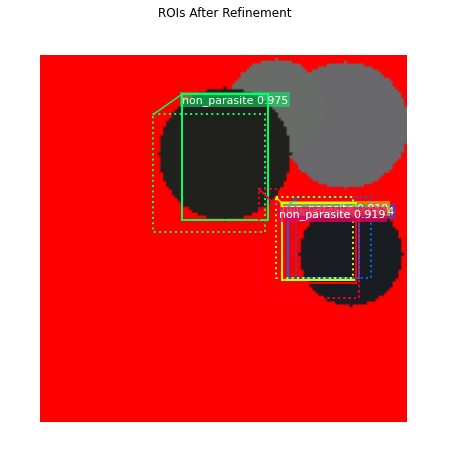

In [27]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

In [128]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 22 detections:
[  0   1   2   6   7  13  14  18  19  20  24  26  40  73  84 122 147 166
 175 183 321 481]


In [129]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 11:
[  0   1   2   6  18  19  40 122 147 166 183]


In [130]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_train.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

non_parasite          : [  0   1   2   6  18  19  40 122 147 166 183] -> [ 0 40]

Kept after per-class NMS: 2
[ 0 40]


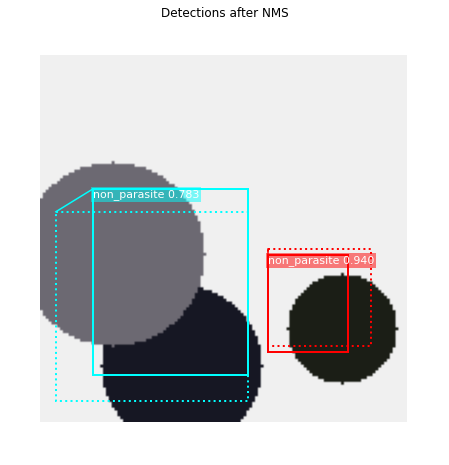

In [131]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

In [95]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

NameError: name 'display_images' is not defined

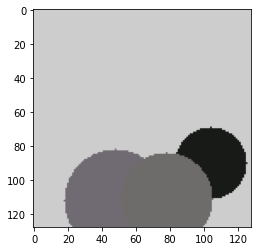

In [90]:
from matplotlib import pyplot as plt
from PIL import Image

plt.imshow(dataset_val.load_image(22))

In [178]:
result

NameError: name 'result' is not defined

In [22]:
from matplotlib.patches import Rectangle
from mrcnn.model import mold_image
from numpy import expand_dims
def display_detection(img_id):
    
    #two_coc = np.asarray(Image.open(name_file))
    two_coc = dataset_val.load_image(img_id)
    sample = expand_dims(mold_image(two_coc,cfg),0) #cfg is the model that we've created
    #get predictions : bounding boxes, classes, etc
    result = model.detect(sample,verbose=0)
    plt.imshow(two_coc)
    ax = plt.gca()
    
    output = result[0] #class_ids, rois, scores, mask
    
    print(output["class_ids"])
    for class_id,roi,score in zip(output["class_ids"],output["rois"],output["scores"]) :
        class_name = dataset_val.class_names[class_id]
        # get coordinates
        y1, x1, y2, x2 = roi
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        color = 'red' if class_id == 1 else 'green'
        rect = Rectangle((x1, y1), width, height, fill=False, color=color)
        # draw the box
        ax.add_patch(rect)
        print('{} : {} , roi : {}'.format(class_name, score, roi))
    return result

In [175]:
dataset_val.class_names

['BG', 'parasite', 'non_parasite']

In [99]:
dataset_val.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

[1 1 1 1 1]
parasite : 0.9999985694885254 , roi : [ 0 40 49 84]
parasite : 0.9999750852584839 , roi : [ 74  68 116 116]
parasite : 0.9998914003372192 , roi : [  7  92  46 128]
parasite : 0.9988327622413635 , roi : [ 74  36 111  73]
parasite : 0.700924813747406 , roi : [  0  89  23 117]


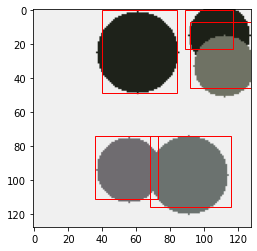

In [23]:
result = display_detection(23)

In [36]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_train.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
19 Positive ROIs
[('BG', 981), ('non_parasite', 16), ('parasite', 3)]


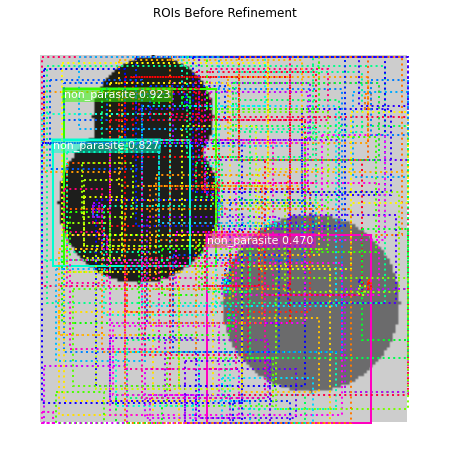

In [38]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

In [103]:
%%time
image_ids = np.random.choice(dataset_val.image_ids, 20)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, cfg,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, cfg), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"]3 r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    #if image_id == 23 :
    #    print("average precision (img 23): ",AP)
    
print("mAP: ", np.mean(APs))

average precision (img 23):  0.444444457689921
mAP:  0.5855555627743403
Wall time: 1min 44s


In [59]:
image_id = 23
image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset_val, cfg,image_id, use_mini_mask=False)
molded_images = np.expand_dims(modellib.mold_image(image, cfg), 0)
# Run object detection
results = model.detect([image], verbose=0)
r = results[0]
print("Number of box found : ",len(r))
# Compute AP
AP, precisions, recalls, overlaps =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'])
print("Image" + str(image_id))
print("Average precision :",AP)
print("Precisions : ",precisions)
print("Recalls : ",recalls)
print("Overlaps : ",overlaps)

Number of box found :  4
Image23
Average precision : 0.41666666666666663
Precisions :  [1.         1.         0.66666667 0.66666667 0.        ]
Recalls :  [0.   0.25 0.25 0.5  1.  ]
Overlaps :  [[0.         0.         0.8401169  0.        ]
 [0.         0.8390203  0.         0.        ]
 [0.07065614 0.         0.         0.7722646 ]]
